scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.7.1 pandas==1.2.0 scikit-learn==0.24.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10
... reading from cache file cache\filtered_gene_bc_matrices-hg19-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)


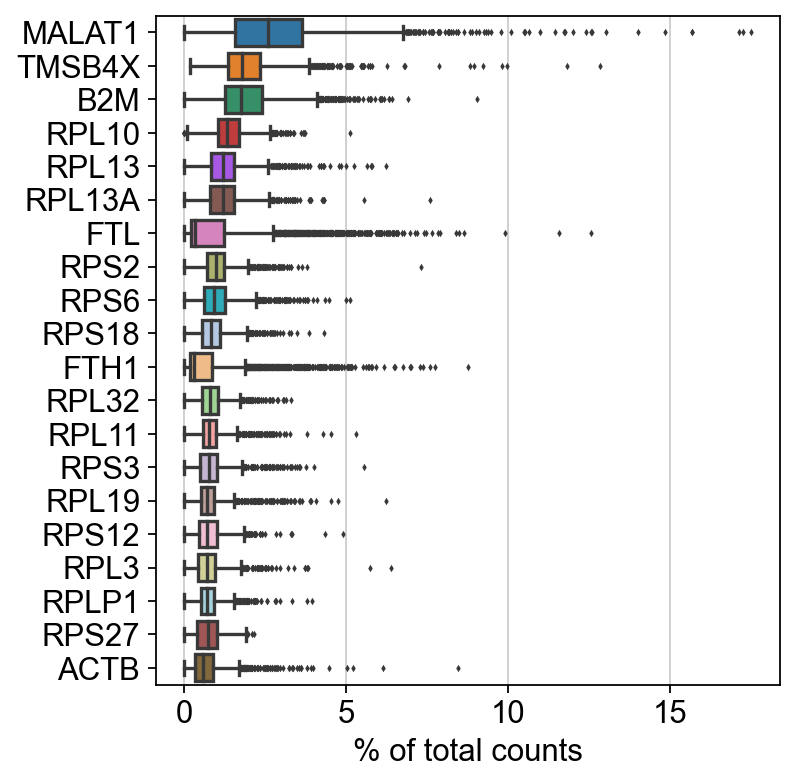

In [88]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
# set resolution/size, styling, format of figures
sc.settings.set_figure_params(dpi = 80, facecolor = "white")

# h5ad -- formatted HDF5, supports *large* complex heterogeneous data
results_file = 'pbmc3k.h5ad' # the file that will store the analysis results

"""
Single-cell RNA sequencing (scRNA-seq) is a powerful technology capable of unveiling cellular heterogeneity of the transcriptome (full range of mRNA expressed by an organism) at
single-cell resolution, producing insights toward subpopulation structures and progression trajectories which would be hidden in bulk cell population RNA sequencing analyses. Enabled by scRNA-seq advances, scRNA-seq is increasingly used and offers the promise of addressing a variety of biology questions, such as intra-population heterogeneity and subpopulation identification, developmental trajectories, and regulatory mechanisms.

scRNA-seq experiments often generate large amounts of data, containing whole-genome gene
expression measurements of thousands or more individual cells, which presents challenges in computational
analysis and interpretation of the data. There are several reasons why computational analysis of scRNA-seq data
is challenging, such as high dimensionality, measurement noise, detection limit, unbalanced size between rare and abundant populations, etc.
One important characteristic of scRNA-seq data that feeds into all these challenges is a phenomenon called “dropout”, where a gene is observed at a low or moderate expression
level in one cell but is not detected in another cell of the same cell type. These dropout events occur due to the low amounts of mRNA in individual cells and inefficient mRNA capture, as well as the stochasticity of mRNA expression. As a result of the dropouts, the scRNA-seq data is often highly sparse. The excessive zero counts cause the data to be zero-inflated, only capturing a small fraction of the transcriptome of each cell.
"""
# Why sparse data

# Read 10x-Genomics-formatted mtx (sparse matrix format with genes on the rows and cells on the columns as output by Cell Ranger) directory. (tab separated values)
adata = sc.read_10x_mtx('filtered_gene_bc_matrices/hg19/', var_names = 'gene_symbols', cache = True)
# directory with .mtx file, gene symbols used for variable names (variable-axis index), cache file for faster subsequent reading

# makes index unique by appending number string to each duplicate element ('1', '2', etc)
adata.var_names_make_unique() # unnecessary if using var_names = gene_ids

#AnnData object with n_obs x n_vars = 2700 x 32738; var: gene_ids

# Trailing comma makes version control easier
sc.pl.highest_expr_genes(adata, n_top=20, ) # plot along observations/variables axes
# Shows different highly expressed genes, percents of total counts across all cells

In [89]:
# FILTERING
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Info is shown because of verbosity

filtered out 19024 genes that are detected in less than 3 cells


![Alt text](image.png)

In [90]:
# Info about mitochondrial genes is important for quality control - responsible for powerhouse
# High proportions indicative of poor-quality cells; loss of cytoplastic RNA from perforated cells
# Mitchondria larger than individual transcript molecules, less likely to escape through tears
# Mitchondrial genes begin with symbols 'MT-', ex MT-ATP6

# Gene symbol (mt) for variable name

# adata objects sliced like pandas dataframes

# annotation of variables as pd.DataFrame /// names of variables
adata.var['mt'] = adata.var_names.str.startswith('MT-') # annotate the group of mitochondrial genes

# quality control metrics -- most efficient on sparse CSR or dense matrix

# adata - annotated data matrix, qc_vars - keys for boolean columns of .var which identify variables you could control for, percent_top -- which proportions of top genes to cover, log1p -- whether or not tranformed annotations (labeling data on images), 
# inplace - whether to place calculated metrics in adata's .obs and .var (pandas.DataFrame - can be used as such)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)



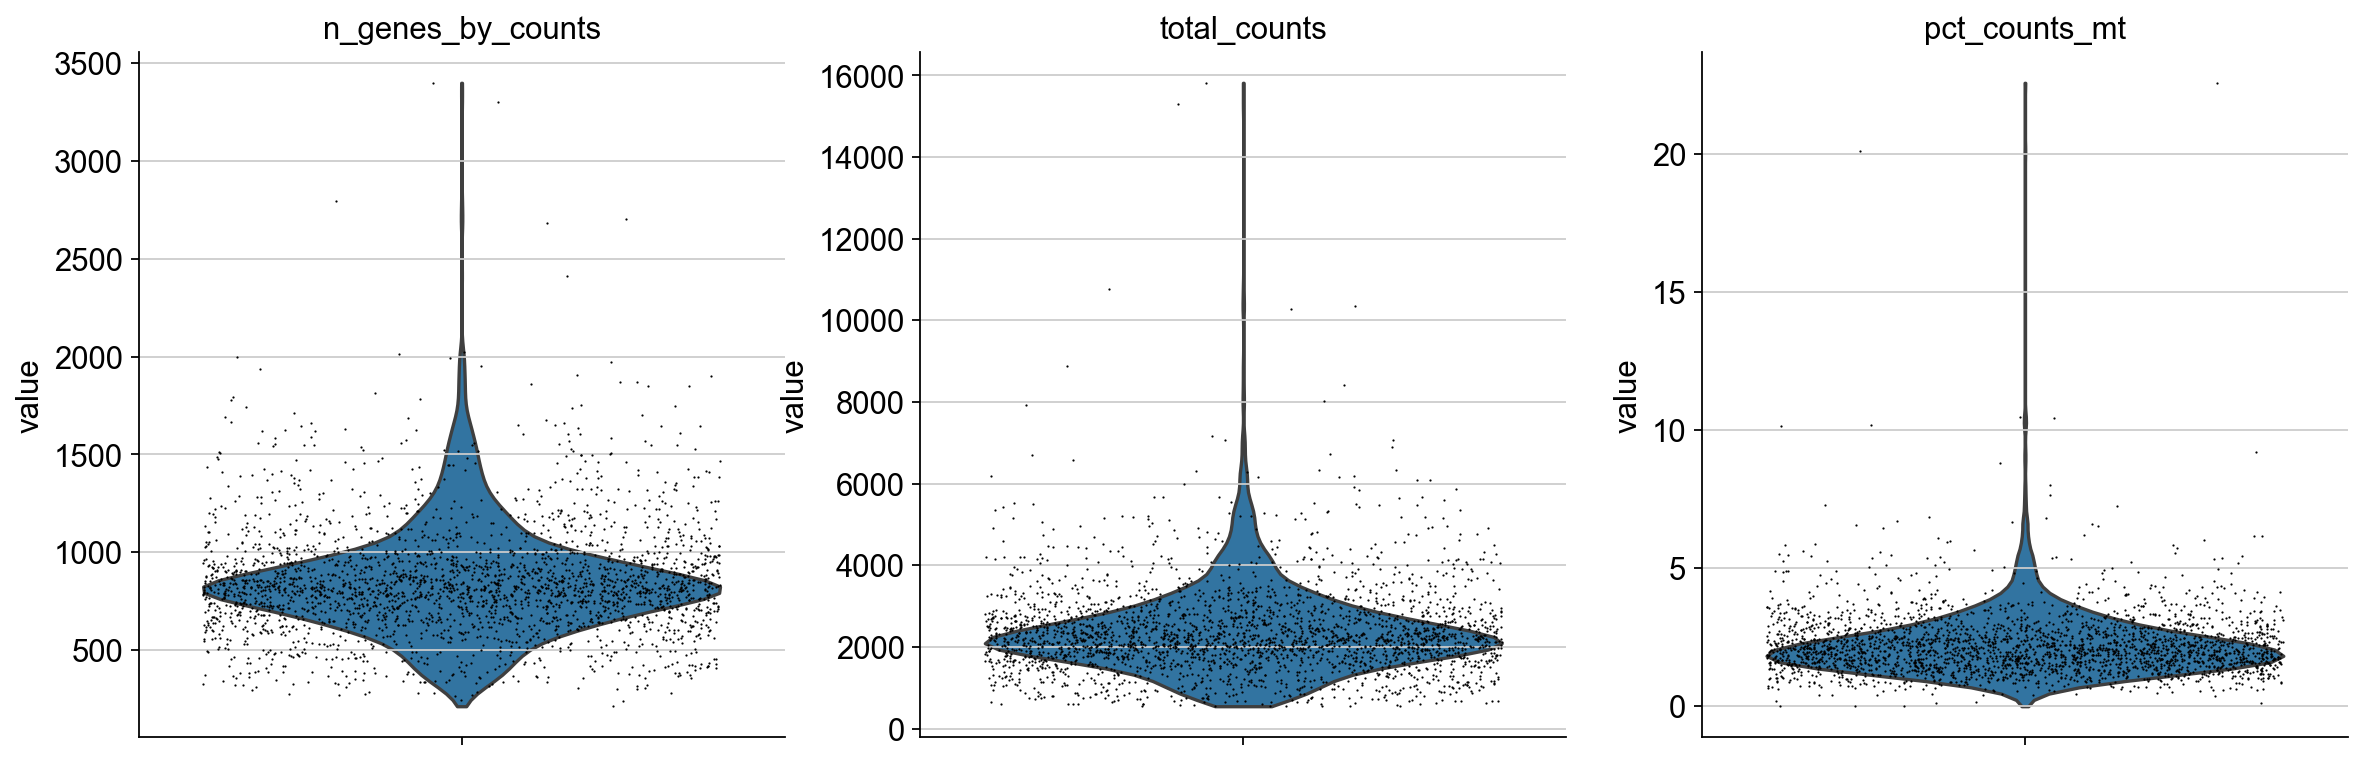

In [91]:
# Violin plot (depicts distributions of numeric data using density curves) of computed quality measures:
# [] -> keys for accessing variables of .var_names/fields of .obs; multi_panel -> display keys in multiple panels
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = 0.4, multi_panel = True)

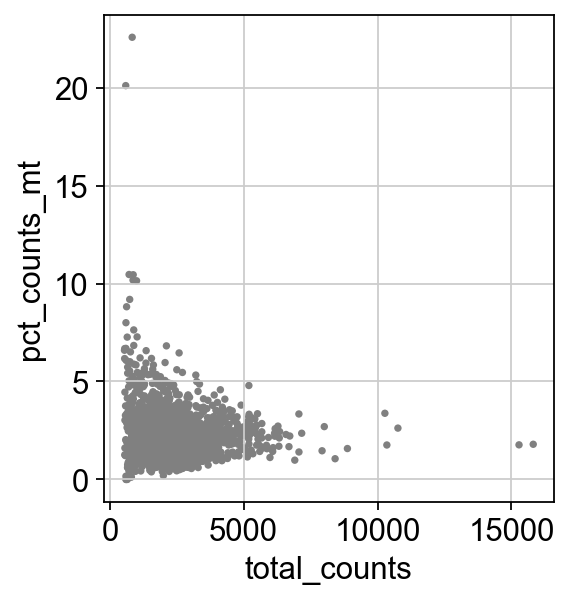

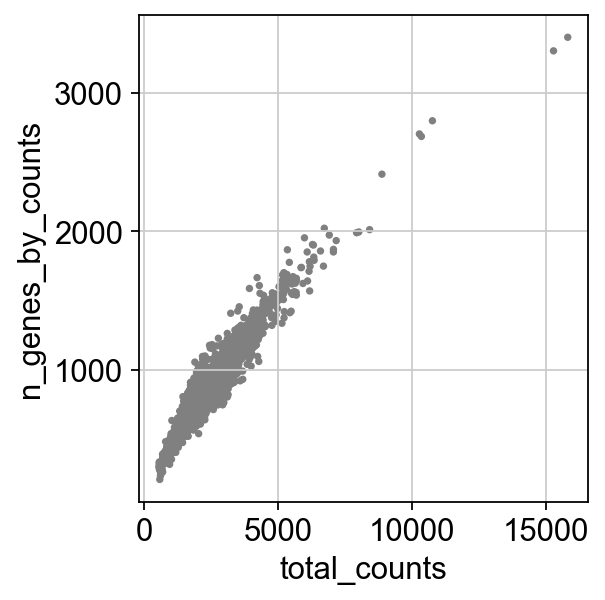

In [92]:
# remove cells that have too many mitochondrial genes expressed or too many counts (Bad)
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt') # proportion of total cells mitocondrial
sc.pl.scatter(adata, x = 'total_counts', y = 'n_genes_by_counts') # number of genes with positive counts (present) in a cell

# total_counts is total number of counts for a cell (library size)

In [93]:
# actual filtering by slicing AnnData object (pandas.dataframe)

# n_obs observations (cells) of n_vars variables (genes)

adata = adata[adata.obs.n_genes_by_counts < 2500, :] # number rna molecules detected per cell
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [94]:
# Total count normalize (library-size-correct) to 10k reads per cell so counts become comparable
# Necessary for accurate comparisons of gene expression between samples
# Counts of mapped reads for each gene is proportional to expression of RNA (interesting) in addition to other factors (uninteresting)
# Normalization - scaling raw count values to account for uninteresting factors.

# Main factors - sequencing depth, gene length, RNA composition

# ex methods - counts per million (sequencing depth), tpm (transcripts per kilobase million)

# RPKM/FPKM, median of ratios, trimmed mean of M values (TMM)...
sc.pp.normalize_total(adata, target_sum=1e4)



normalizing counts per cell
    finished (0:00:00)


C:\Users\Matt Yang\AppData\Roaming\Python\Python39\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [95]:
# logarithimize data; when original continuous data does not follow bell curve, log transform to make it as normal as possible -- reduces skewdness
# caveat - should follow log-normal distribution

sc.pp.log1p(adata) # natural logarithm of one plus the input array

# annotate highly variable genes; expect logarithmized data.
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

extracting highly variable genes


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


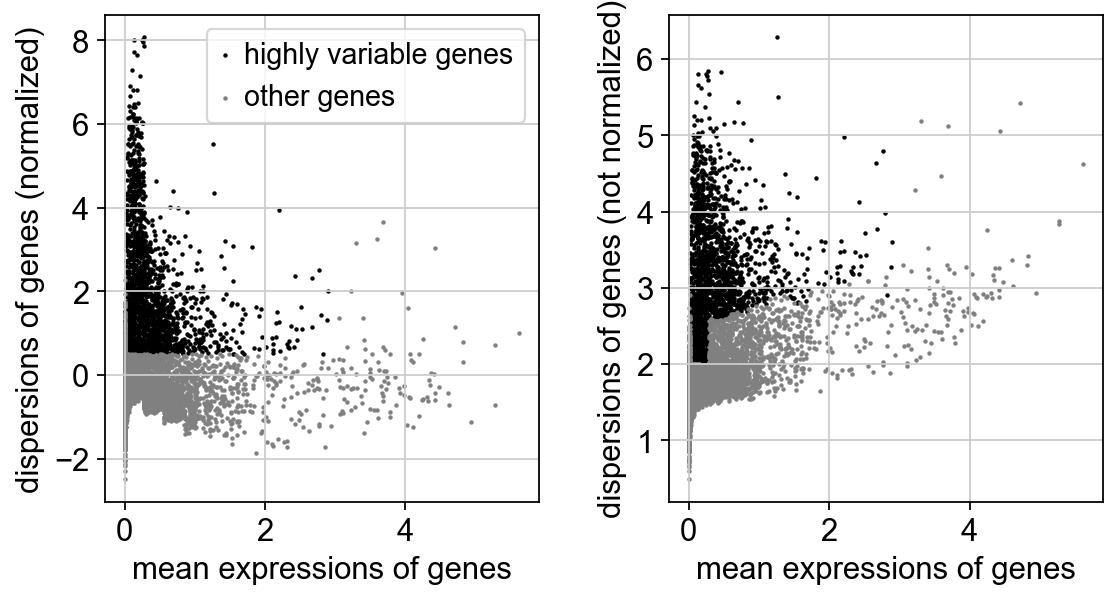

In [96]:
sc.pl.highly_variable_genes(adata)

In [97]:
adata.raw = adata # freezes state of AnnData; saves for lter use in testing/visualizations

# If you don't proceed with correcting data with sc.pp.regress_out and scaling it via sc.pp.scale,
# no need to use .raw

# result of this detection is stored as annotation in .var.highly_variable and auto-detected by PCA
# (principal component analysis) to reduce dimensionality of large datasets, by transforming large
# set into smaller one sitll containing most info

In [98]:
adata = adata[:, adata.var.highly_variable] # actually do filtering

In [99]:
# regress out effects of total counts, percentage of mitochondrial genes expressed
# scale to unit variance
# [] -> keys for observation annotation on which to regress on
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # regress out mostly unwanted sources of variation -- examine variable in isolation

sc.pp.scale(adata, max_value=10)

# PCA - reduce dimensionality of data by revealing main axes of variation, denoising
sc.tl.pca(adata, svd_solver = 'arpack') # linear algebra stuff (code which computes eigenvalues and eigenvectors of large matricies)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


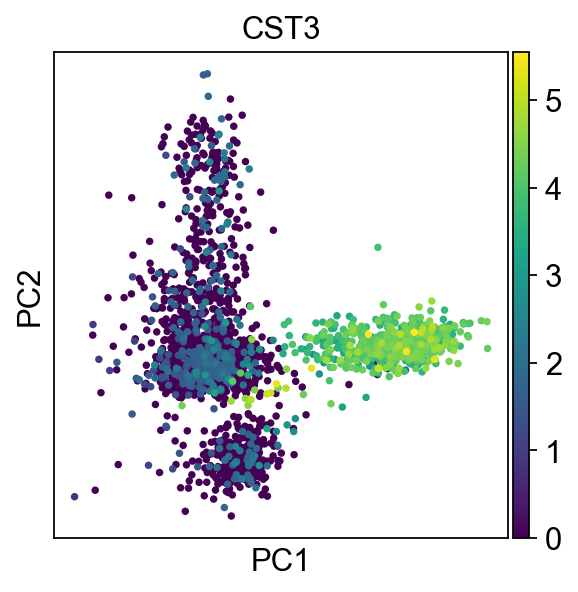

In [100]:
sc.pl.pca(adata, color = 'CST3') # scatterplot of PCA coordinates (unused later)

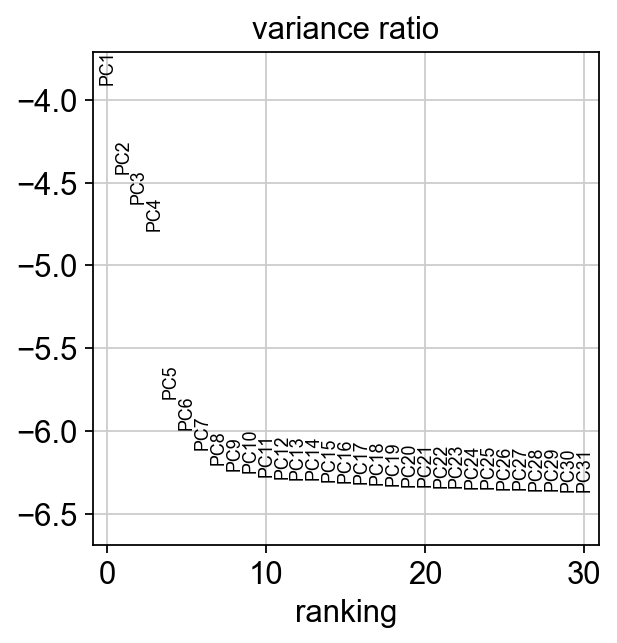

In [101]:
sc.pl.pca_variance_ratio(adata, log = True) # variance - average squared deviations from the mean; standard deviation is the square root of this number
# both reflect variability in dist
# variance ratio test -> f-ratio test -- demonstrates whether the variance of two populations from which the samples have been drawn is equal or not

In [102]:
adata.write(results_file)

"""
Write .h5ad-formatted hdf5 file.

Generally, if you have sparse data that are stored as a dense-mostly nonzero values in matrix, you can dramatically improve performance and reduce disk space by converting to a ~scipy.sparse.csr_matrix:

    from scipy.sparse import csr_matrix
    adata.X = csr_matrix(adata.X)
"""

'\nWrite .h5ad-formatted hdf5 file.\n\nGenerally, if you have sparse data that are stored as a dense-mostly nonzero values in matrix, you can dramatically improve performance and reduce disk space by converting to a ~scipy.sparse.csr_matrix:\n\n    from scipy.sparse import csr_matrix\n    adata.X = csr_matrix(adata.X)\n'

In [103]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [104]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [105]:
# Embedding (dense numerical representation of real-world object, expressed as a vector) graph in two dimensions using UMAP 
# uniform manifold approximation and projection -- dimension reduction technique that can be used for visualization similarly to t-SNE,
# as well as general non-linear dimension reduction

# founded on assumption that data is uniformly distributed on Riemannian manifold

"""

If disconnected clusters and similar connectivity violations

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
"""

#sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)
# previous plots showed "raw" (normalized, logarithmized, uncorrected) gene expression
# plot scaled and corrected gene expression by explicitly stating you don't want to use .raw

"\n\nIf disconnected clusters and similar connectivity violations\n\nsc.tl.paga(adata)\nsc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph\nsc.tl.umap(adata, init_pos='paga')\n"

In [106]:
# Clustering

# Leiden graph-clustering method - hierarchial clustering algorithm that recursively merges
# communities into single nodes
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


C:\Users\Matt Yang\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


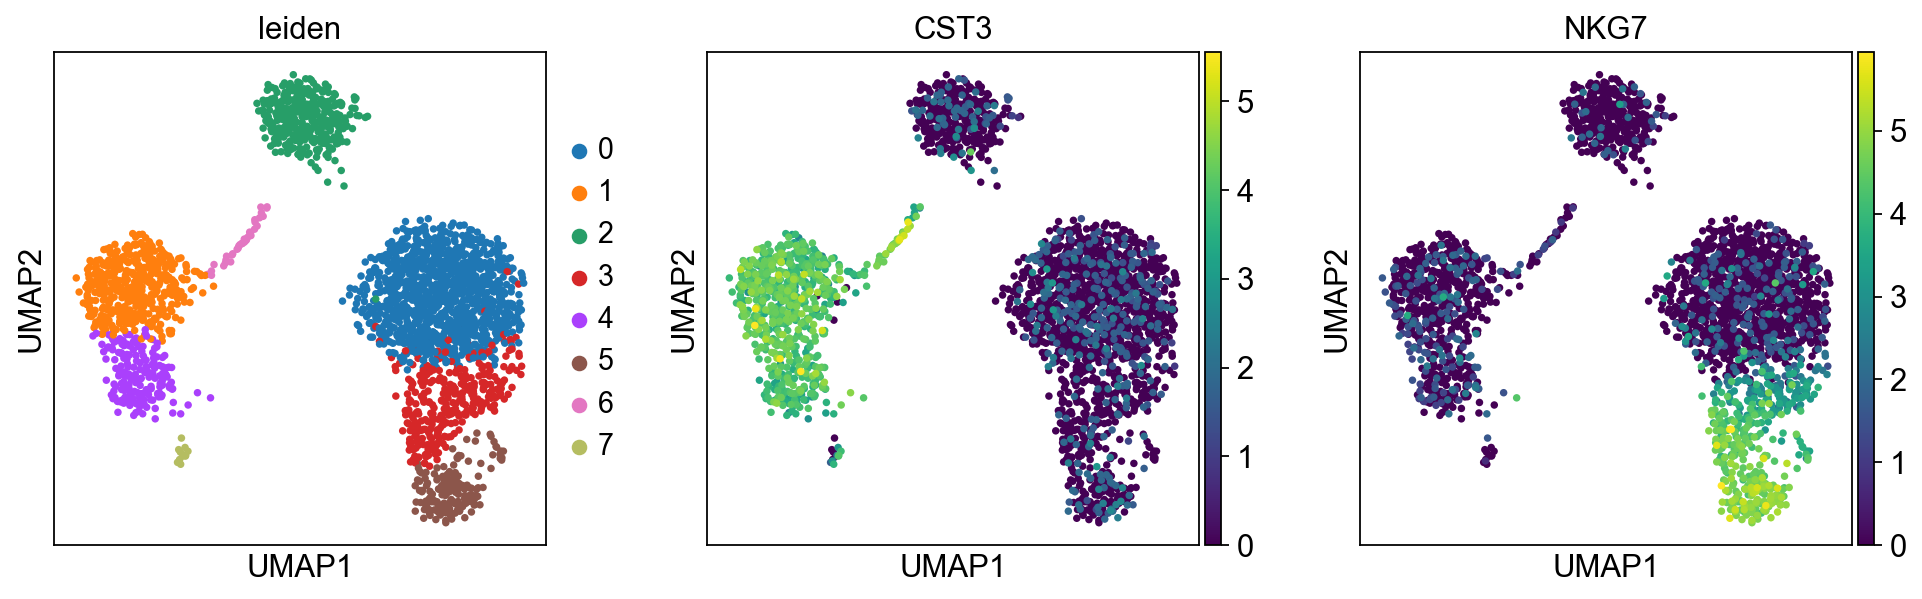

In [107]:
sc.tl.umap(adata) # compute umap layout first
sc.pl.umap(adata, color = ['leiden', 'CST3', 'NKG7'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


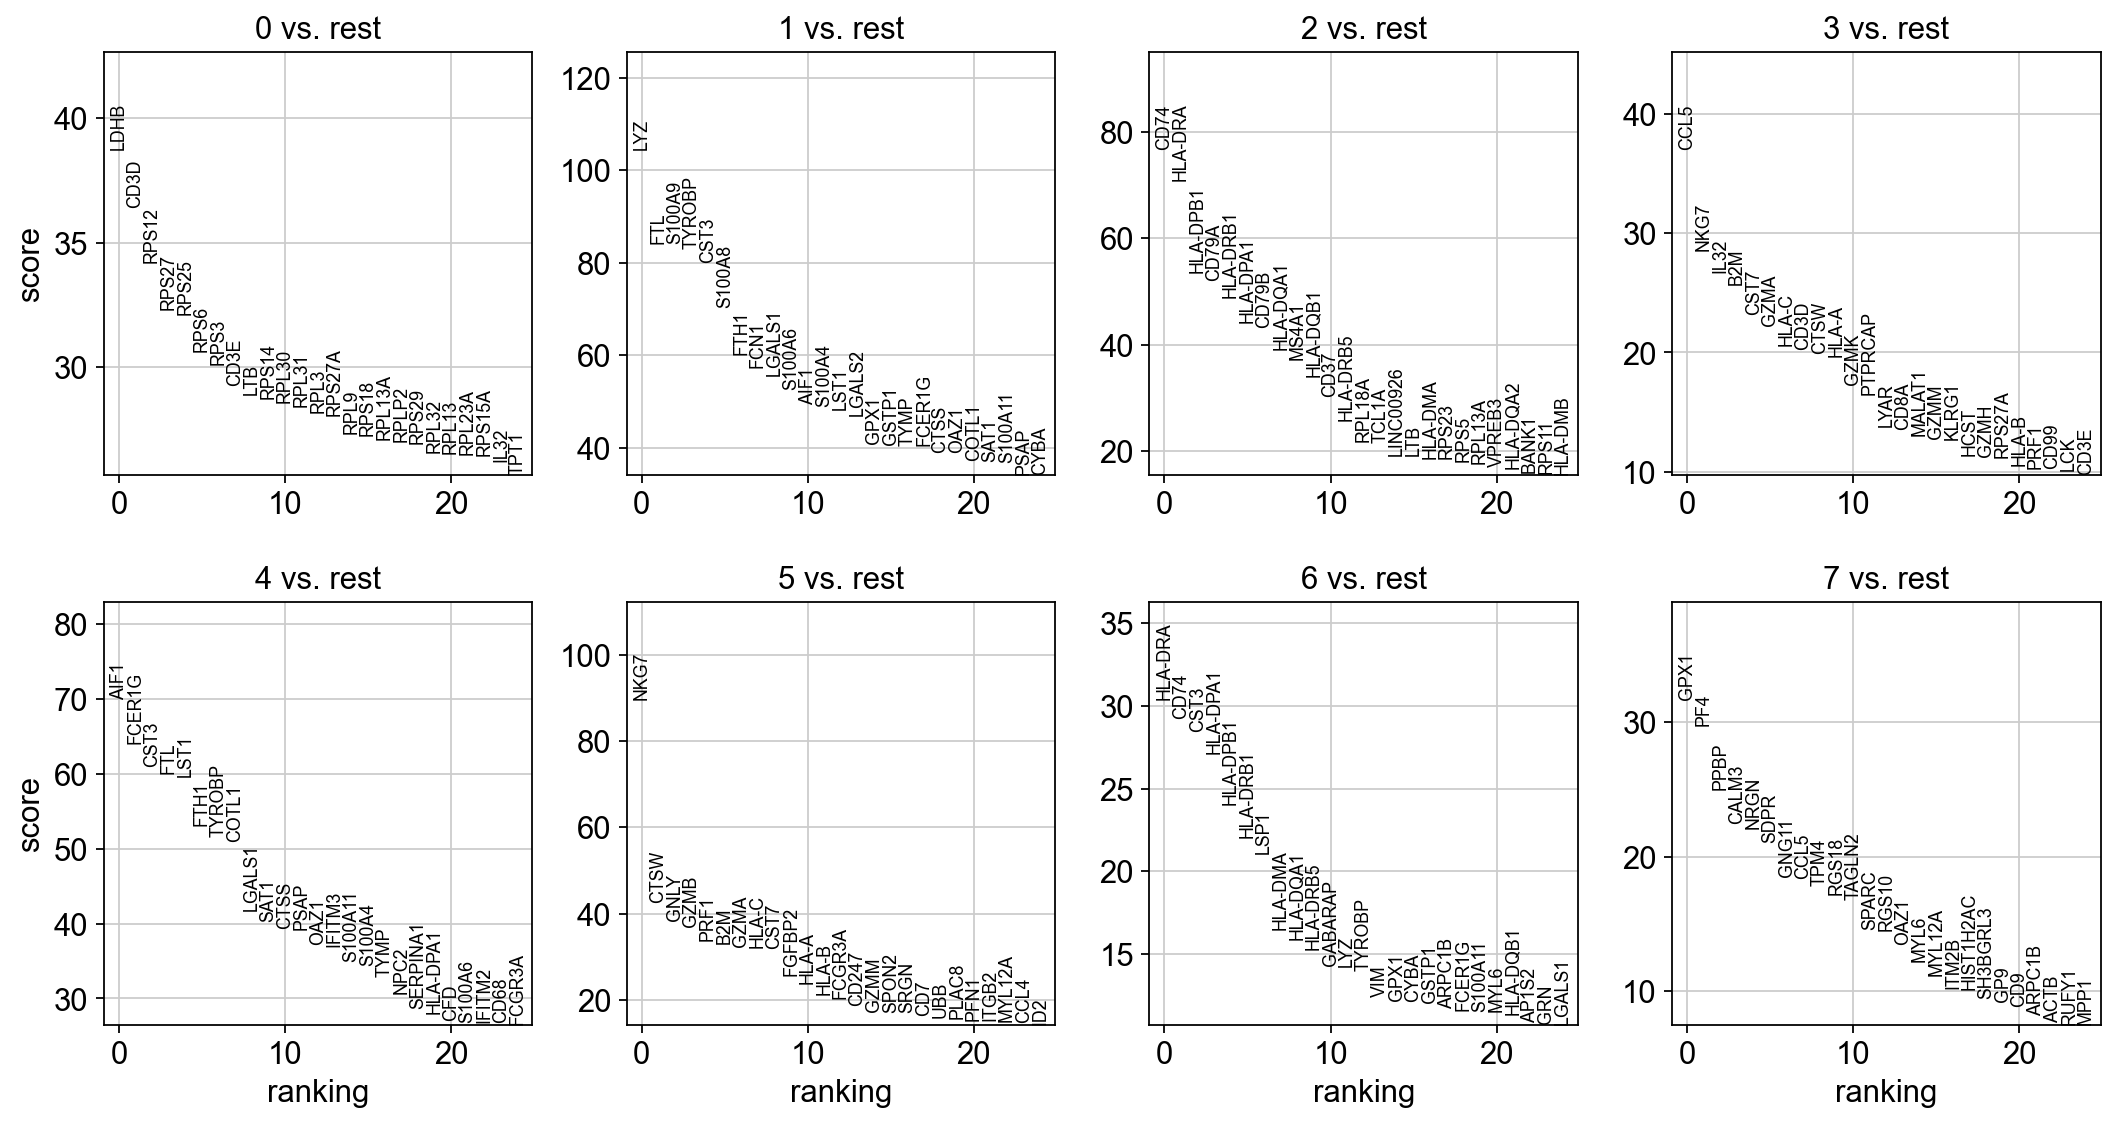

In [108]:
# Finding marker genes ( gene used to determine if nucleic acid sequence has been successfully inserted)
# highly differential genes

# rank genes for characterizing groups - expects logarithmized data
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [109]:
sc.settings.verbosity = 2

# T scores; larger T score = greater difference

ranking genes
    finished (0:00:02)


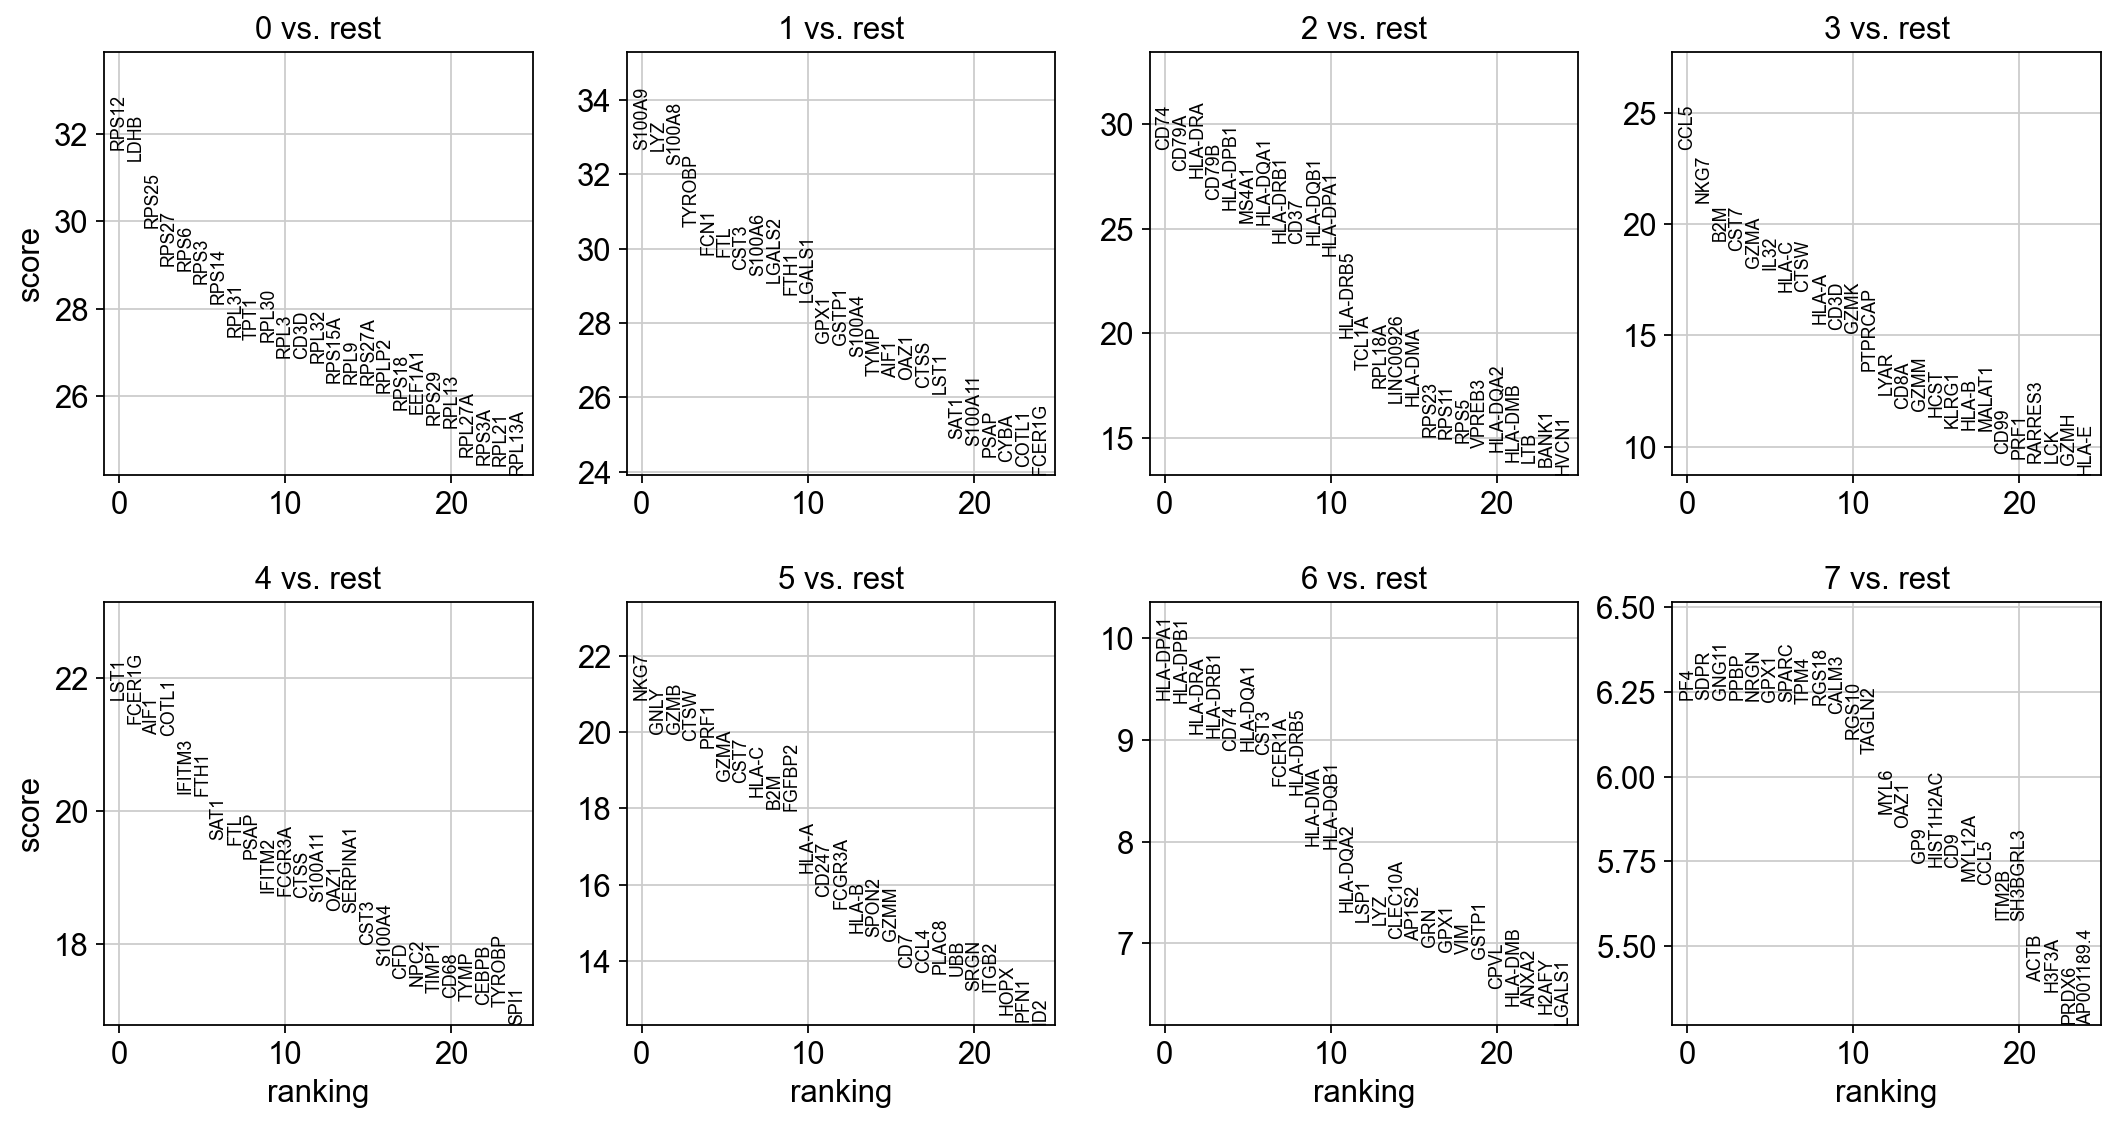

In [110]:
# Wilcoxon rank sum - non parametric version of two-sample t-test (recommended)
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) # sharey=false; each yaxis on graph has own range

In [111]:
adata.write(results_file)

ranking genes
    finished (0:00:04)


c:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


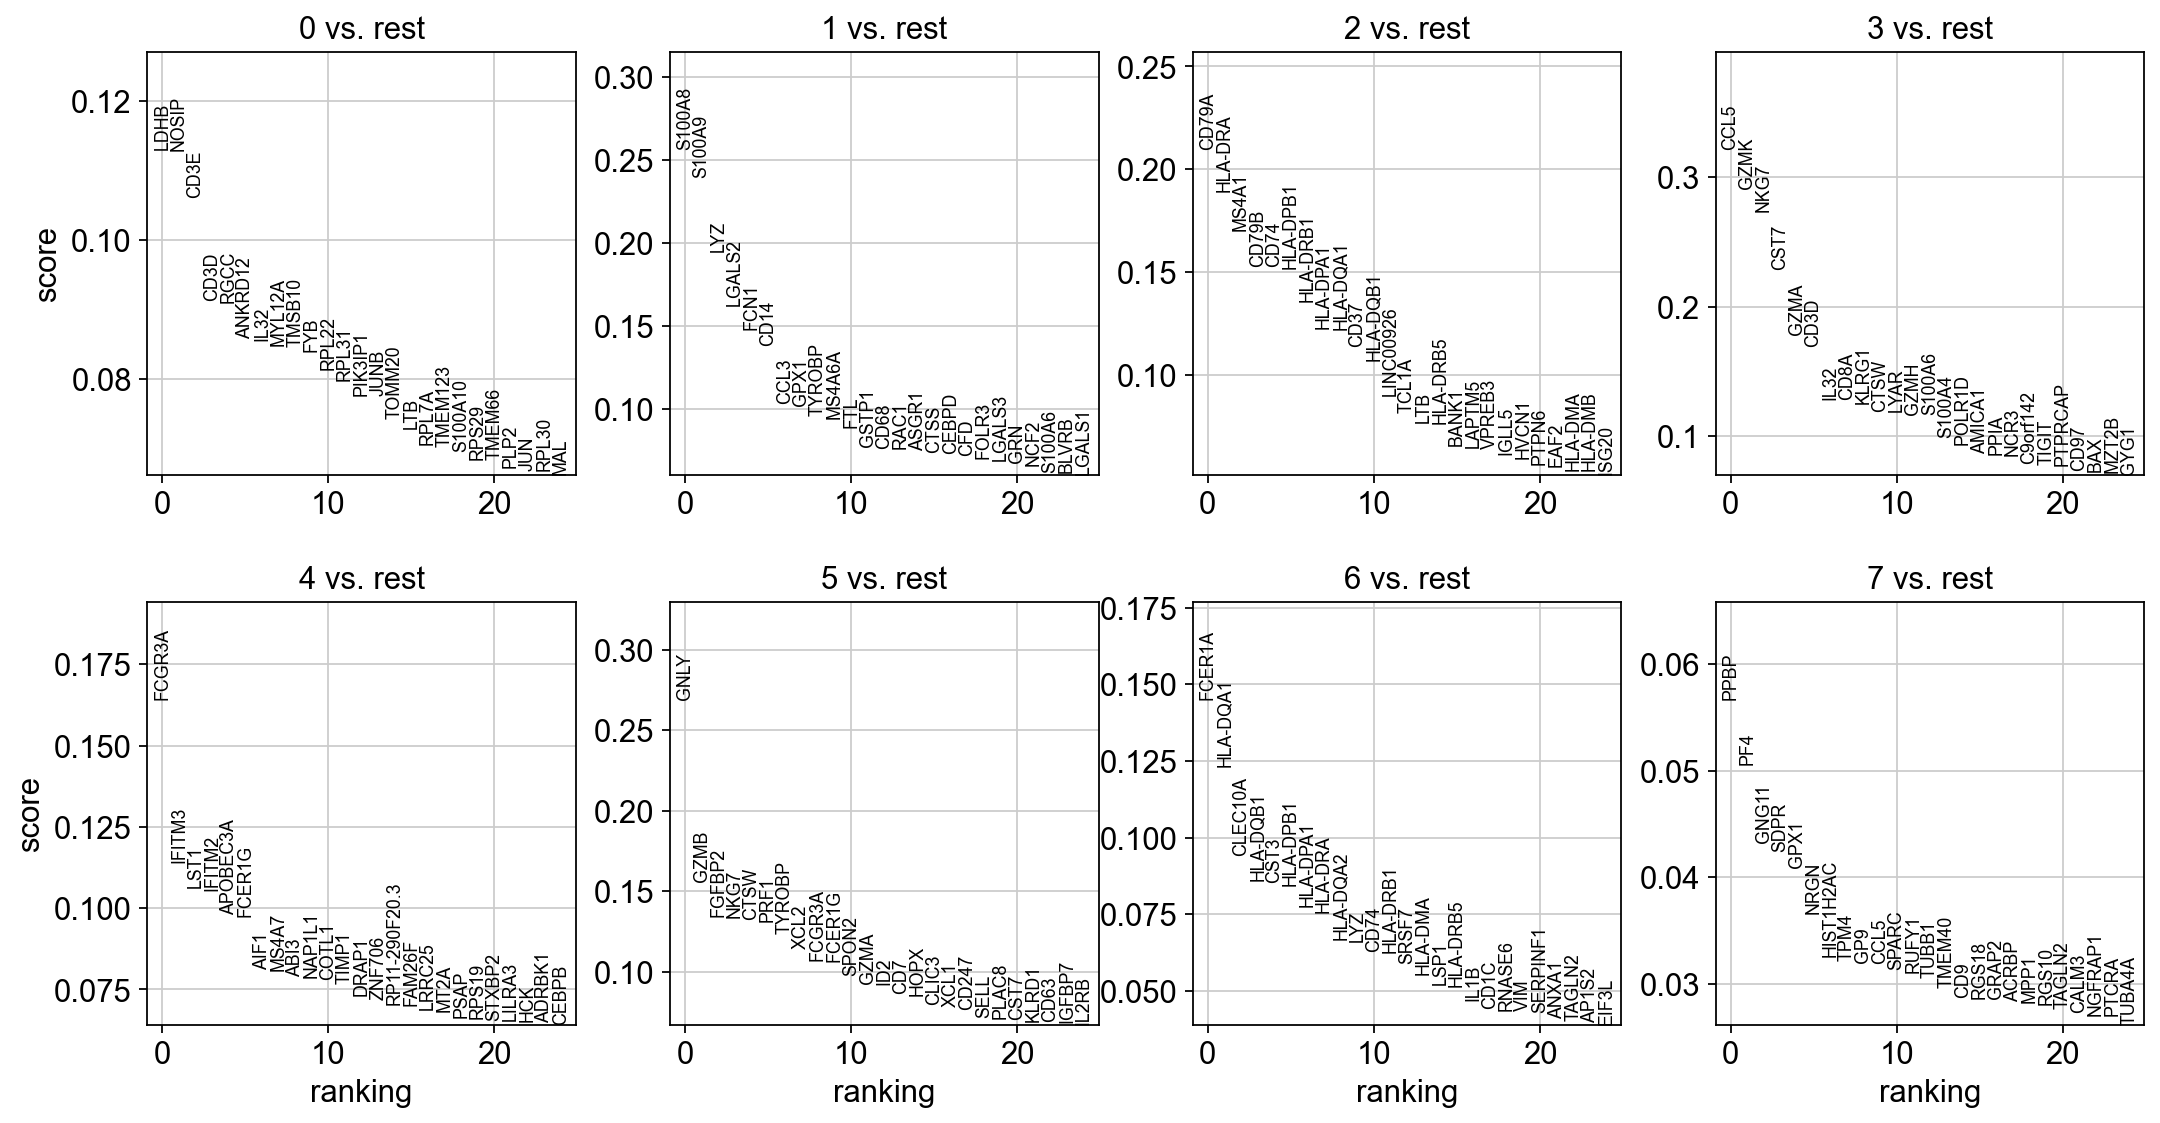

In [112]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'logreg') # rank using logistic regression (score=probability)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Louvain method - extract communities from large networks
# cell markers - type of marker specifically expressed

In [113]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [114]:
adata = sc.read(results_file)

In [115]:
# show top 10 ranked genes per cluster of lovaine in a dataframe
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5) # Head(n) returns first n rows

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,IFITM3,PRF1,CD74,NRGN


In [116]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,1.079322e-219,S100A9,5.013557e-234,CD74,3.043536e-182,CCL5,1.408736e-120,LST1,2.733939e-104,NKG7,1.203971e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,2.807446e-216,LYZ,1.276687e-233,CD79A,6.860832e-170,NKG7,1.947176e-97,FCER1G,8.235039e-101,GNLY,1.257170e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,8.782142e-196,S100A8,2.135223e-228,HLA-DRA,8.398068e-166,B2M,1.645740e-82,AIF1,2.582775e-99,GZMB,1.429027e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,8.804024e-185,TYROBP,2.136387e-205,CD79B,1.171444e-153,CST7,6.188112e-79,COTL1,3.696354e-99,CTSW,4.144726e-87,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,2.266808e-183,FCN1,8.605073e-196,HLA-DPB1,6.167786e-148,GZMA,1.004637e-72,IFITM3,2.486695e-91,PRF1,1.692100e-85,CD74,5.853161e-19,NRGN,4.800511e-10


ranking genes
    finished (0:00:01)


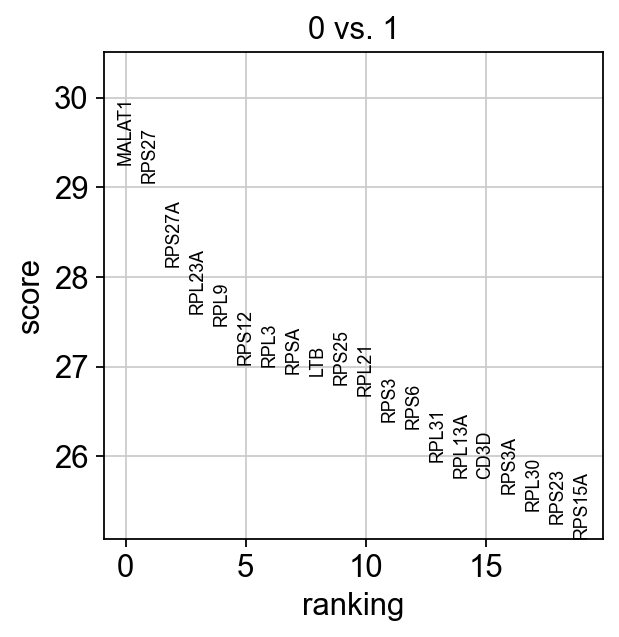

In [120]:
adata.uns['log1p']["base"] = None # ERROR.
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

C:\Users\Matt Yang\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


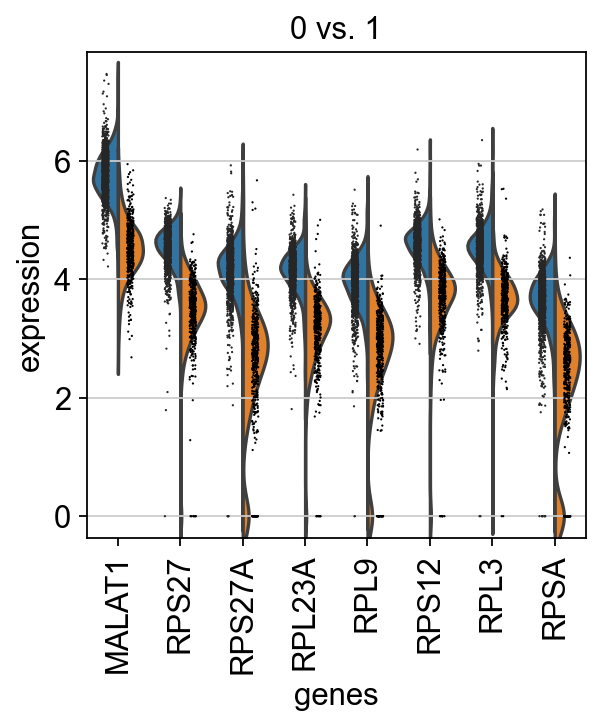

In [121]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby = 'leiden')